### Predict Product Prices using the open-source models

Introduction to LoRA and QLoRA

In [2]:
!pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-multimodal 1.1.1 requires accelerate<0.22.0,>=0.21.0, but you have accelerate 1.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires jsonschema<4.22,>=4.18, but you have jsonschema 4.23.0 which is incompatible.
autogluon-multimodal 1.1.1 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2 which is incompatible.
autogluon-multimodal 1.1.1 requires scipy<1.13,>=1.5.4, but you have scipy 1.14.1 which is incompatible.
autogluon-multimodal 1.1.1 requires transformers[sentencepiece]<4.41.0,>=4.38.0, but you have transformers 4.48.1 which is incompatible.
autogluon-timeseries 1.1.1 requires 

In [1]:
# imports

import os
import re
import math
from tqdm import tqdm
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datetime import datetime

2025-01-21 19:45:19.056551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 19:45:19.077637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 19:45:19.084204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 19:45:19.099917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
FINETUNED_MODEL = f"ed-donner/pricer-2024-09-13_13.04.39"

# Hyperparameters for QLoRA Fine-Tuning

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token)

In [4]:
# lets check if GPU available

import torch
print(torch.cuda.is_available())

True


In [5]:
# loading the llama base model

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [6]:
print(f"Memoryused by the base model: {base_model.get_memory_footprint() / 1e9:,.1f} GB")

Memoryused by the base model: 32.1 GB


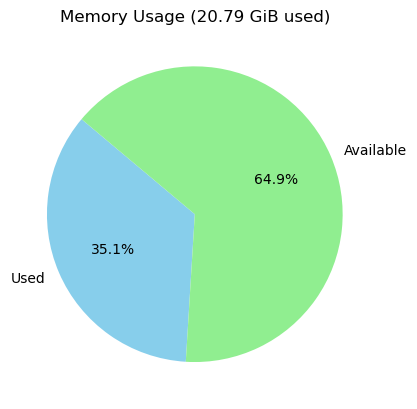

In [11]:
# Lets see how the memeory is split CPU vs GPU
#This is for CPU

import matplotlib.pyplot as plt
import psutil

# Get memory stats
mem = psutil.virtual_memory()

# Data to plot
labels = ['Used', 'Available']
sizes = [mem.used, mem.available]
colors = ['skyblue', 'lightgreen']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title with GiB used
plt.title(f'Memory Usage ({mem.used / (1024 ** 3):.2f} GiB used)')

# Show plot
plt.show()

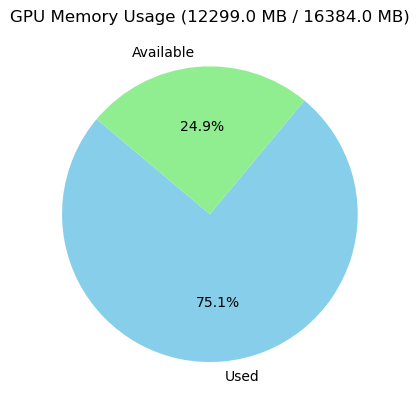

In [12]:
#This is for GPU Usage

import GPUtil
import matplotlib.pyplot as plt

# Get GPU stats
GPUs = GPUtil.getGPUs()
gpu = GPUs[0]  # Assuming you have one GPU

# Data to plot
labels = ['Used', 'Available']
sizes = [gpu.memoryUtil * 100, (1 - gpu.memoryUtil) * 100]  # Use memoryUtil
colors = ['skyblue', 'lightgreen']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title with memory used
plt.title(f'GPU Memory Usage ({gpu.memoryUsed} MB / {gpu.memoryTotal} MB)')

# Show plot
plt.show()

## Lets try quantization and check how much memory is used to load the Meta-Llama-3.1-8B version
### Trying the 8 bit quant using the bitsAndBytes Config

In [5]:
# Configuration for 8-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True
)

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quantization_config,
    torch_dtype=torch.float16
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
print(f"Memoryused by the base model: {base_model.get_memory_footprint() / 1e9:,.1f} GB")

Memoryused by the base model: 9.1 GB


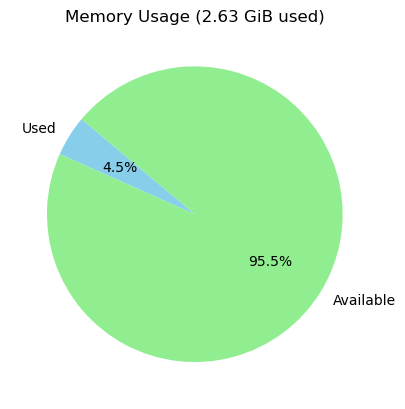

In [7]:
# Lets see how the memeory is split CPU vs GPU
#This is for CPU

import matplotlib.pyplot as plt
import psutil

# Get memory stats
mem = psutil.virtual_memory()

# Data to plot
labels = ['Used', 'Available']
sizes = [mem.used, mem.available]
colors = ['skyblue', 'lightgreen']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title with GiB used
plt.title(f'Memory Usage ({mem.used / (1024 ** 3):.2f} GiB used)')

# Show plot
plt.show()

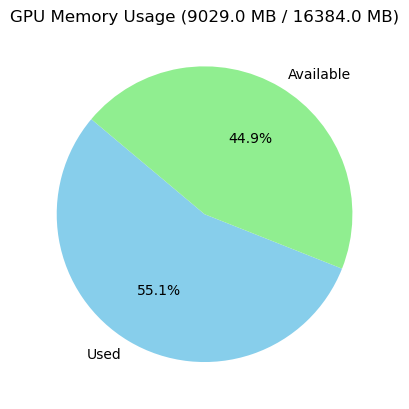

In [8]:
#This is for GPU Usage

import GPUtil
import matplotlib.pyplot as plt

# Get GPU stats
GPUs = GPUtil.getGPUs()
gpu = GPUs[0]  # Assuming you have one GPU

# Data to plot
labels = ['Used', 'Available']
sizes = [gpu.memoryUtil * 100, (1 - gpu.memoryUtil) * 100]  # Use memoryUtil
colors = ['skyblue', 'lightgreen']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title with memory used
plt.title(f'GPU Memory Usage ({gpu.memoryUsed} MB / {gpu.memoryTotal} MB)')

# Show plot
plt.show()

### Getting the Llama model all the way to 4 bit quant using the bitsAndBytes Config

In [6]:
# Configuration for 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enables 4-bit quantization
    bnb_4bit_use_double_quant=True,  # double quantization for slightly better performance
    bnb_4bit_quant_type="nf4",  # NF4 quantization (recommended)
    bnb_4bit_compute_dtype=torch.bfloat16  # Optional: Use bfloat16 for faster computation
)

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quantization_config,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
print(f"Memoryused by the base model: {base_model.get_memory_footprint() / 1e9:,.1f} GB")

Memoryused by the base model: 5.6 GB


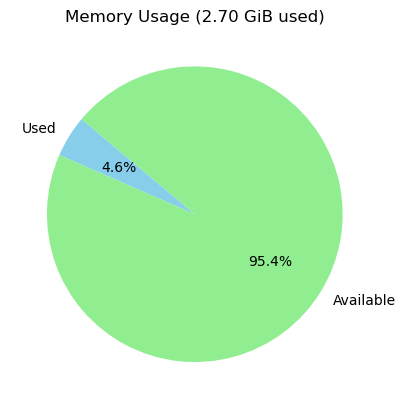

In [8]:
# Lets see how the memeory is split CPU vs GPU
#This is for CPU

import matplotlib.pyplot as plt
import psutil

# Get memory stats
mem = psutil.virtual_memory()

# Data to plot
labels = ['Used', 'Available']
sizes = [mem.used, mem.available]
colors = ['skyblue', 'lightgreen']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title with GiB used
plt.title(f'Memory Usage ({mem.used / (1024 ** 3):.2f} GiB used)')

# Show plot
plt.show()

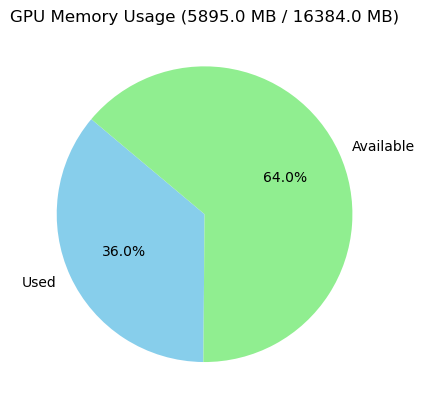

In [9]:
#This is for GPU Usage

import GPUtil
import matplotlib.pyplot as plt

# Get GPU stats
GPUs = GPUtil.getGPUs()
gpu = GPUs[0]  # Assuming you have one GPU

# Data to plot
labels = ['Used', 'Available']
sizes = [gpu.memoryUtil * 100, (1 - gpu.memoryUtil) * 100]  # Use memoryUtil
colors = ['skyblue', 'lightgreen']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title with memory used
plt.title(f'GPU Memory Usage ({gpu.memoryUsed} MB / {gpu.memoryTotal} MB)')

# Show plot
plt.show()

## Now lets compare fine-tuned model vs base-model (Using PEFT)(Parameter-Efficient Fine-Tuning)

In [10]:
fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

In [11]:
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e9:,.2f} GB")

Memory footprint: 5.70 GB


In [12]:
# without fine tuning it is 5.6 GB and with fine tuning it is 5.70 GB

In [13]:
# Each of the Target Modules has 2 LoRA Adaptor matrices, called lora_A and lora_B
# These are designed so that weights can be adapted by adding alpha * lora_A * lora_B
# Let's count the number of weights using their dimensions:

# See the matrix dimensions above
lora_q_proj = 4096 * 32 + 4096 * 32
lora_k_proj = 4096 * 32 + 1024 * 32
lora_v_proj = 4096 * 32 + 1024 * 32
lora_o_proj = 4096 * 32 + 4096 * 32

# Each layer comes to
lora_layer = lora_q_proj + lora_k_proj + lora_v_proj + lora_o_proj

# There are 32 layers
params = lora_layer * 32

# So the total size in MB is
size = (params * 4) / 1_000_000

print(f"Total number of params: {params:,} and size {size:,.1f}MB")

Total number of params: 27,262,976 and size 109.1MB
